<a href="https://colab.research.google.com/github/shivangibithel/assignment2/blob/main/FaceRecognition/Face-Recognition-master/LDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [75]:
# Import libraries
from matplotlib import pyplot as plt
from matplotlib.image import imread
from numpy.linalg import inv
import numpy as np
import os

In [76]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [77]:
dataset_path = '/content/drive/MyDrive/dataset/'
dataset_dir  = os.listdir(dataset_path)

width  = 92
height = 112

Train Images:


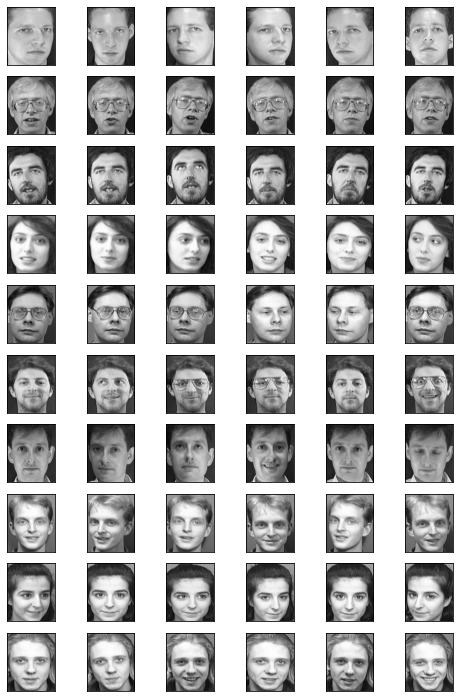

Test Images:


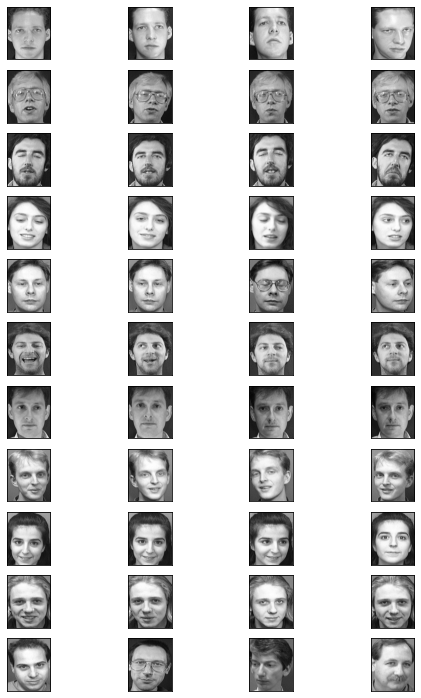

In [78]:
number_of_classes=10
img_in_class=6

print('Train Images:')

# to store all the training images in an array
training_tensor   = np.ndarray(shape=(number_of_classes*img_in_class, height*width), dtype=np.float64)

for i in range(number_of_classes):
    for j in range(img_in_class):
        img = plt.imread(dataset_path + 'training1/s'+str(i+1)+'/'+str(j+1)+'.pgm')
        # copying images to the training array
        training_tensor[img_in_class*i+j,:] = np.array(img, dtype='float64').flatten()
        # plotting the training images
        plt.subplot(number_of_classes,img_in_class,1+img_in_class*i+j)
        plt.imshow(img, cmap='gray')
        plt.subplots_adjust(right=1.2, top=2.5)
        plt.tick_params(labelleft=False, labelbottom=False, bottom=False,top=False,right=False,left=False, which='both')
plt.show()

print('Test Images:')
testing_tensor   = np.ndarray(shape=(44, height*width), dtype=np.float64)

for i in range(44):
    img = imread(dataset_path + 'test/'+str(i+1)+'.pgm')
    testing_tensor[i,:] = np.array(img, dtype='float64').flatten()
    plt.subplot(11,4,1+i)
    plt.imshow(img, cmap='gray')
    plt.subplots_adjust(right=1.2, top=2.5)
    plt.tick_params(labelleft=False, labelbottom=False, bottom=False,top=False,right=False,left=False, which='both')
plt.show()

## Apply PCA on the given data and make a database of projected faces

In [79]:
def PCA(training_tensor, number_chosen_components):
    
    mean_face = np.zeros((1,height*width))
    for i in training_tensor:
        mean_face = np.add(mean_face,i)
    mean_face = np.divide(mean_face,float(training_tensor.shape[0])).flatten()
    
#     plt.title('Mean face')
#     plt.imshow(mean_face.reshape(height, width), cmap='gray')
#     plt.tick_params(labelleft=False, labelbottom=False, bottom=False,top=False,right=False,left=False, which='both')
#     plt.show()
    
#     print('Normalized faces:')
    normalised_training_tensor = np.ndarray(shape=(training_tensor.shape))
    for i in range(training_tensor.shape[0]):
        normalised_training_tensor[i] = np.subtract(training_tensor[i],mean_face)        
#     for i in range(len(training_tensor)):
#         img = normalised_training_tensor[i].reshape(height,width)
#         plt.subplot(10,6,1+i)
#         plt.imshow(img, cmap='gray')
#         plt.subplots_adjust(right=1.2, top=2.5)
#         plt.tick_params(labelleft=False, labelbottom=False, bottom=False,top=False,right=False,left=False, which='both')
#     plt.show()
    cov_matrix = np.cov(normalised_training_tensor)
    cov_matrix = np.divide(cov_matrix,float(training_tensor.shape[0]))
 
    eigenvalues, eigenvectors, = np.linalg.eig(cov_matrix)
    eig_pairs = [(eigenvalues[index], eigenvectors[:,index]) for index in range(len(eigenvalues))]

    # Sort the eigen pairs in descending order:
    eig_pairs.sort(reverse=True)
    eigvalues_sort  = [eig_pairs[index][0] for index in range(len(eigenvalues))]
    eigvectors_sort = [eig_pairs[index][1] for index in range(len(eigenvalues))]
    
    reduced_data = np.array(eigvectors_sort[:number_chosen_components]).transpose()

    proj_data = np.dot(training_tensor.transpose(),reduced_data)
    proj_data = proj_data.transpose()
    
#     print('Projected Data:')
#     for i in range(proj_data.shape[0]):
#         img = proj_data[i].reshape(height,width)
#         plt.subplot(10,10,1+i)
#         plt.imshow(img, cmap='jet')
#         plt.tick_params(labelleft=False, labelbottom=False, bottom=False,top=False,right=False,left=False, which='both')
#         plt.subplots_adjust(right=1.2, top=2.5)
#     plt.show()

    wx = np.array([np.dot(proj_data,img) for img in normalised_training_tensor])
    
    return proj_data, wx

In [80]:
# get the projected faces
number_chosen_components = 30
projected_data, projected_sig = PCA(training_tensor, number_chosen_components)
projected_sig.shape

(60, 30)

## Mean of each class and global mean

In [81]:
mew = np.zeros((number_of_classes, number_chosen_components))
M = np.zeros((1,number_chosen_components))

for i in range(number_of_classes):
    xa = projected_sig[img_in_class*i:img_in_class*i+img_in_class,:]
    for j in xa:
        mew[i,:] = np.add(mew[i,:],j)
    mew[i,:] = np.divide(mew[i,:],float(len(xa)))

for i in projected_sig:
    M = np.add(M,i)
M = np.divide(M,float(len(projected_sig)))

M.shape
mew.shape

(10, 30)

## Within class scatter matrix

In [82]:
# normalised within class data
normalised_wc_proj_sig = np.ndarray(shape=(number_of_classes*img_in_class, number_chosen_components), dtype=np.float64)

for i in range(number_of_classes):
    for j in range(img_in_class):
        normalised_wc_proj_sig[i*img_in_class+j,:] = np.subtract(projected_sig[i*img_in_class+j,:],mew[i,:])
normalised_wc_proj_sig.shape

sw = np.zeros((number_chosen_components,number_chosen_components))

for i in range(number_of_classes):
    xa = normalised_wc_proj_sig[img_in_class*i:img_in_class*i+img_in_class,:]
    xa = xa.transpose()
    cov = np.dot(xa,xa.T)
    sw = sw + cov
sw.shape

(30, 30)

## Between class scatter matrix


In [83]:
normalised_proj_sig = np.ndarray(shape=(number_of_classes*img_in_class, number_chosen_components), dtype=np.float64)
for i in range(number_of_classes*img_in_class):
    normalised_proj_sig[i,:] = np.subtract(projected_sig[i,:],M)

sb = np.dot(normalised_proj_sig.T,normalised_proj_sig)
sb = np.multiply(sb,float(img_in_class))
sb.shape

(30, 30)

## Use the criterion function


In [84]:
J = np.dot(inv(sw), sb)
J.shape

(30, 30)

## eigenvalues and eigenvectors

In [85]:
eigenvalues, eigenvectors, = np.linalg.eig(J)
# eigenvectors = abs(eigenvectors)
print('Eigenvectors of Cov(X):')
print(eigenvectors)
# eigenvalues = abs(eigenvalues)
print('Eigenvalues of Cov(X):',eigenvalues)

Eigenvectors of Cov(X):
[[ 1.59757645e-01+0.00000000e+00j -7.15667560e-03+0.00000000e+00j
   5.60077375e-02+0.00000000e+00j  8.03832716e-02+0.00000000e+00j
   7.06894939e-02+0.00000000e+00j -4.47066709e-02+0.00000000e+00j
  -3.15354593e-02+0.00000000e+00j -4.77853728e-02+0.00000000e+00j
  -2.50625701e-02+0.00000000e+00j -1.04941220e-02-3.51744940e-03j
  -1.04941220e-02+3.51744940e-03j -6.38202695e-03-5.93121723e-04j
  -6.38202695e-03+5.93121723e-04j -2.50190956e-02+1.28332161e-02j
  -2.50190956e-02-1.28332161e-02j -2.24052599e-03+1.08153327e-03j
  -2.24052599e-03-1.08153327e-03j -6.09008924e-04+1.02520954e-03j
  -6.09008924e-04-1.02520954e-03j -2.75829321e-03-3.34256103e-03j
  -2.75829321e-03+3.34256103e-03j  7.82522354e-03+0.00000000e+00j
   5.58894951e-04+2.11540110e-03j  5.58894951e-04-2.11540110e-03j
   3.22028976e-03+0.00000000e+00j  7.41568323e-04+0.00000000e+00j
   1.97729061e-03+0.00000000e+00j -3.28686138e-03+1.32764016e-03j
  -3.28686138e-03-1.32764016e-03j -2.53980961e-03+0.

Cumulative proportion of variance explained vector: [0.4470741 +0.00000000e+00j 0.60776913+0.00000000e+00j
 0.74283633+0.00000000e+00j 0.82252567+0.00000000e+00j
 0.88190617+0.00000000e+00j 0.92922527+0.00000000e+00j
 0.95080185+0.00000000e+00j 0.96664737+0.00000000e+00j
 0.97686039+0.00000000e+00j 0.97796227+9.47770161e-18j
 0.97906416+0.00000000e+00j 0.98016605+1.63633058e-17j
 0.98126793+0.00000000e+00j 0.98236982+9.00519692e-18j
 0.98347171+0.00000000e+00j 0.98457359+3.56984983e-18j
 0.98567548+0.00000000e+00j 0.98677736+0.00000000e+00j
 0.98787925+0.00000000e+00j 0.98898114+1.33013755e-17j
 0.99008302+0.00000000e+00j 0.99118491+0.00000000e+00j
 0.9922868 +0.00000000e+00j 0.99338868+2.71066256e-18j
 0.99449057+0.00000000e+00j 0.99559245+1.61060128e-18j
 0.99669434+0.00000000e+00j 0.99779623+0.00000000e+00j
 0.99889811+3.82623751e-18j 1.        +0.00000000e+00j]


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


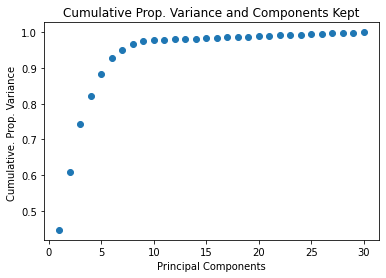

In [86]:
# get corresponding eigenvectors to eigen values
# so as to get the eigenvectors at the same corresponding index to eigen values when sorted
eig_pairs = [(eigenvalues[index], eigenvectors[:,index]) for index in range(len(eigenvalues))]

# Sort the eigen pairs in descending order:
eig_pairs.sort(reverse=True)
eigvalues_sort  = [eig_pairs[index][0] for index in range(len(eigenvalues))]
eigvectors_sort = [eig_pairs[index][1] for index in range(len(eigenvalues))]

# Find cumulative variance of each principle component
var_comp_sum = np.cumsum(eigvalues_sort)/sum(eigvalues_sort)

# Show cumulative proportion of varaince with respect to components
print("Cumulative proportion of variance explained vector:", var_comp_sum)

# x-axis for number of principal components kept
num_comp = range(1,len(eigvalues_sort)+1)
plt.title('Cumulative Prop. Variance and Components Kept')
plt.xlabel('Principal Components')
plt.ylabel('Cumulative. Prop. Variance ')

plt.scatter(num_comp, var_comp_sum)
plt.show()

In [87]:
print('Number of eigen vectors:',len(eigvalues_sort))

# Choosing the necessary number of principle components
number_chosen_components = 9
print("k:",number_chosen_components)
reduced_data = np.array(eigvectors_sort[:number_chosen_components]).transpose()
reduced_data.shape

Number of eigen vectors: 30
k: 9


(30, 9)

## Fisher faces

In [88]:
projected_sig.shape
FP = np.dot(projected_sig, reduced_data)
FP.shape

(60, 9)

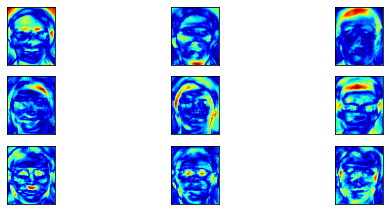

In [89]:
# get projected data ---> eigen space

proj_data1 = np.dot(training_tensor.transpose(),FP)
proj_data1 = proj_data1.transpose()
proj_data1.shape

# plotting of eigen faces --> the information retained after applying lossing transformation
for i in range(proj_data1.shape[0]):
    img = proj_data1[i].reshape(height,width)
    #print(img)
    plt.subplot(10,3,1+i)
    plt.imshow((img.real*img.real + img.imag*img.imag)**0.5, cmap='jet')
    plt.subplots_adjust(right=1.2, top=2.5)
    plt.tick_params(labelleft=False, labelbottom=False, bottom=False,top=False,right=False,left=False, which='both')
plt.show()

## Mean face

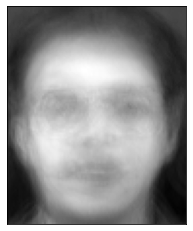

In [90]:
mean_face = np.zeros((1,height*width))

for i in training_tensor:
    mean_face = np.add(mean_face,i)

mean_face = np.divide(mean_face,float(len(training_tensor))).flatten()

plt.imshow(mean_face.reshape(height, width), cmap='gray')
plt.tick_params(labelleft=False, labelbottom=False, bottom=False,top=False,right=False,left=False, which='both')
plt.show()

## Testing

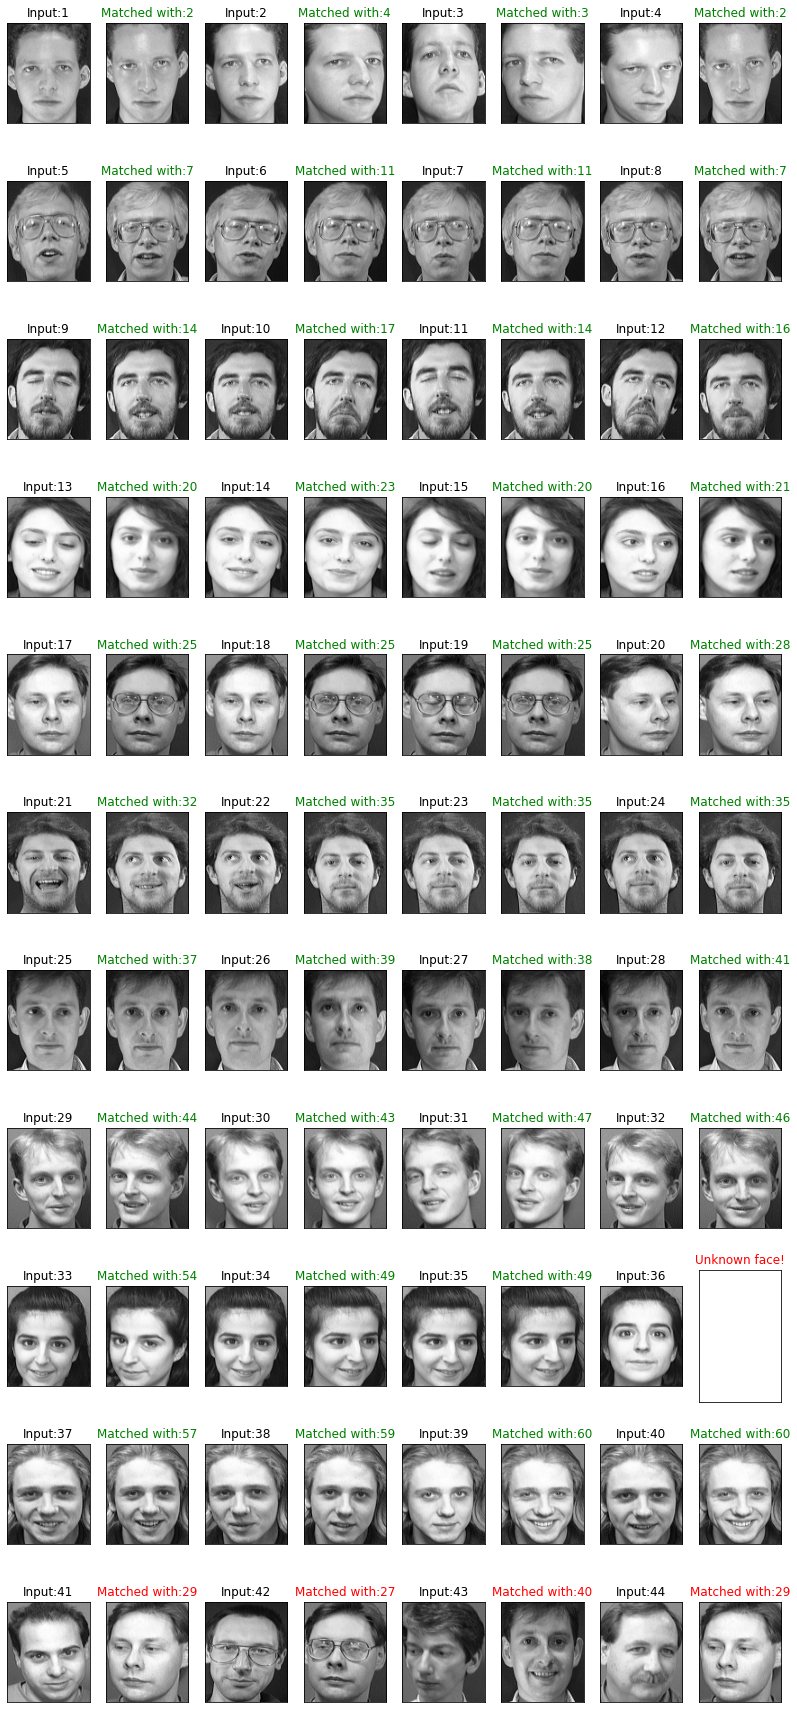

Correct predictions: 39/44 = 88.63636363636364%


In [91]:
# Testing all the images

count=0
num_images=0
correct_pred=0
def recogniser(img_number):
    global count,highest_min,num_images,correct_pred
    
    num_images          += 1
    unknown_face_vector = testing_tensor[img_number,:]
    normalised_uface_vector = np.subtract(unknown_face_vector,mean_face)
    
    plt.subplot(11,8,1+count)
    plt.imshow(unknown_face_vector.reshape(height,width), cmap='gray')
    plt.title('Input:'+str(img_number+1))
    plt.subplots_adjust(right=1.2, top=2.5)
    plt.tick_params(labelleft=False, labelbottom=False, bottom=False,top=False,right=False,left=False, which='both')
    count+=1
    
    PEF = np.dot(projected_data,normalised_uface_vector)
    proj_fisher_test_img = np.dot(reduced_data.T,PEF)
    diff  = FP - proj_fisher_test_img
    norms = np.linalg.norm(diff, axis=1)
    mean_ = np.mean(norms)
    # print(norms)
    # print("mean:",mean_)
    index = np.argmin(norms)

    dist = np.min(norms)
    # print(dist)
  


    
    plt.subplot(11,8,1+count)
    
    set_number = int(img_number/4)
#     print(set_number)

    t0 = 7000000
    
#     if(img_number>=40):
#         print(norms[index])
    
    if norms[index] < t0:
      if(index>=(6*set_number) and index<(6*(set_number+1))):
          plt.title('Matched with:'+str(index+1), color='g')
          plt.imshow(training_tensor[index,:].reshape(height,width), cmap='gray')
          correct_pred += 1
      else:
          plt.title('Matched with:'+str(index+1), color='r')
          plt.imshow(training_tensor[index,:].reshape(height,width), cmap='gray')
    else:
        if(img_number>=40):
            plt.title('Unknown face!', color='g')
            correct_pred += 1
        else:
            plt.title('Unknown face!', color='r')
    plt.subplots_adjust(right=1.2, top=2.5)
    plt.tick_params(labelleft=False, labelbottom=False, bottom=False,top=False,right=False,left=False, which='both')
    count+=1
    return dist

fig = plt.figure(figsize=(10, 10))
for i in range(len(testing_tensor)):
    recogniser(i)


plt.show()

print('Correct predictions: {}/{} = {}%'.format(correct_pred, num_images, correct_pred/num_images*100.00))

## Plotting of Accuracy vs m-value for eigenvectors


Total Number of eigenvectors: 30


Text(0.5, 1.0, 'Accuracy vs. k-value')

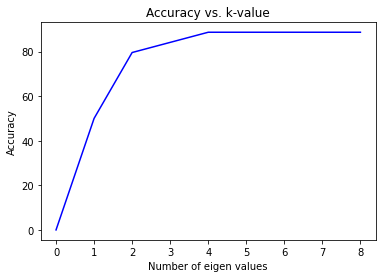

In [92]:
accuracy = np.zeros(9)

def tester(img_number,reduced_data,FP,num_images,correct_pred):
    
    num_images          += 1
    unknown_face_vector = testing_tensor[img_number,:]
    normalised_uface_vector = np.subtract(unknown_face_vector,mean_face)
    
    PEF = np.dot(projected_data,normalised_uface_vector)
    proj_fisher_test_img = np.dot(reduced_data.T,PEF)
    diff  = FP - proj_fisher_test_img
    norms = np.linalg.norm(diff, axis=1)
    index = np.argmin(norms)
    
    set_number = int(img_number/4)

    t0 = 7000000
    
    if norms[index] < t0:
      if(index>=(6*set_number) and index<(6*(set_number+1))):
          correct_pred += 1
    else:
        if(img_number>=40):
            correct_pred += 1
    
    return num_images,correct_pred

def calculate(k):
    
#     print("k:",k)
    reduced_data = np.array(eigvectors_sort[:k]).transpose()
    
    FP = np.dot(projected_sig, reduced_data)
    
    num_images=0
    correct_pred=0
    
    for i in range(len(testing_tensor)):
        num_images,correct_pred = tester(i,reduced_data,FP,num_images,correct_pred)
#     print(FP.shape)
    accuracy[k] = correct_pred/num_images*100.00
    
print('Total Number of eigenvectors:',len(eigvalues_sort))
for i in range(1,9):
    calculate(i)
    
fig, axi = plt.subplots()  
axi.plot(np.arange(9), accuracy, 'b')  
axi.set_xlabel('Number of eigen values')  
axi.set_ylabel('Accuracy')  
axi.set_title('Accuracy vs. k-value') 

# Plot decision boundary LDA

https://melaniesoek0120.medium.com/principal-component-analysis-pca-facial-recognition-5e1021f55151


In [93]:
print("Number of features:", len(training_tensor[0]))

Number of features: 10304


In [94]:
from sklearn.model_selection import cross_validate
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report

In [95]:
y=[]
for i in range(10):
  for j in range(6):
    y.append(i)
training_tensor=np.array(training_tensor)

y=np.array(y)

In [96]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(training_tensor, y)

In [97]:
pca = PCA(n_components=30)
X_pca =pca.fit(training_tensor)        

TypeError: ignored

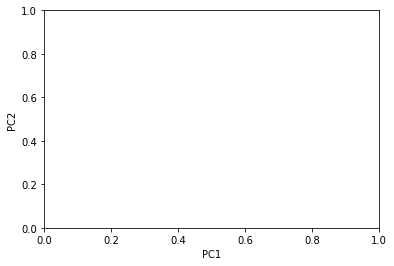

In [98]:
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.scatter(
    X_pca[:,0],
    X_pca[:,1],
    c=y,
    cmap='rainbow',
    alpha=0.7,
    edgecolors='b'
)
plt.title("Eigenfaces for AT&T dataset")
plt.show()

In [102]:
lda = LinearDiscriminantAnalysis(n_components=9)
X_lda = lda.fit_transform(pca.transform(training_tensor), y)
# test_transformed = lda.transform(pca.transform(self.X_test))

In [101]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis(n_components=1)
X_lda = lda.fit(training_tensor, y).transform(training_tensor)

In [ ]:
X_lda[y == i]

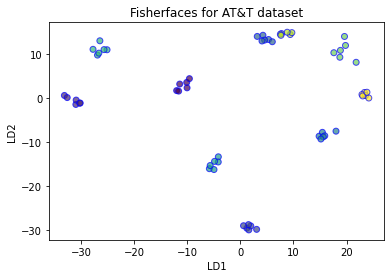

In [105]:
plt.xlabel('LD1')
plt.ylabel('LD2')
plt.scatter(
    X_lda[:,0],
    X_lda[:,1],
    c=y,
    alpha=0.7,
    edgecolors='b'
)
plt.title("Fisherfaces for AT&T dataset")
plt.show()

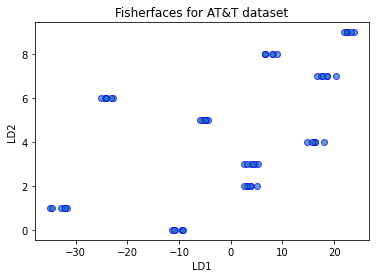

In [99]:
plt.xlabel('LD1')
plt.ylabel('LD2')
plt.scatter(
    X_lda[:,0],
    y,
    alpha=0.7,
    edgecolors='b'
)
plt.title("Fisherfaces for AT&T dataset")
plt.show()

In [ ]:
plt.figure()
# colors = ['navy', 'turquoise']
for i in range(len(y)):
    plt.scatter(X_lda[:,0], X_lda[:,1], alpha=.8)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('LDA of IRIS dataset')
plt.show()